In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import torch
import collections
from scipy.linalg import expm,norm
import glob
import open3d as o3d
import struct
import matplotlib.pyplot as plt
from tqdm import tqdm



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/root/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/root/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/root/.venv/lib/python3.10/site-packages/ipykernel/kernelap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import socket
print("Running on:", socket.gethostname())

Running on: TrainModel


<h2> Build PointNet++ </h2>

In [4]:
# helper functions:
def farthest_point_sample(xyz, npoint):
    batch_size, n, _ = xyz.shape
    device = xyz.device
    centroids = torch.zeros(batch_size, npoint, dtype=torch.long).to(device)
    distance = torch.ones(batch_size, n).to(device) * 1e10
    farthest = torch.randint(0, n, (batch_size,), dtype=torch.long).to(device)
    batch_indices = torch.arange(batch_size, dtype=torch.long).to(device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].unsqueeze(1)  # [B, 1, 3]
        dist = torch.sum((xyz - centroid) ** 2, -1)  # Squared distance [B, N]
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]  # Index of the farthest point

    return centroids


def gather_points(points, idx):
    """
    points: [B, N, C]
    idx: [B, S] or [B, S, K]
    Output: [B, S, C] or [B, S, K, C]
    """
    B = points.shape[0]
    if idx.dim() == 2:
        batch_indices = torch.arange(B, dtype=torch.long, device=points.device).view(B, 1).repeat(1, idx.shape[1])
        return points[batch_indices, idx]  # [B, S, C]
    elif idx.dim() == 3:
        B, S, K = idx.shape
        C = points.shape[2]
        idx_expand = idx.unsqueeze(-1).expand(-1, -1, -1, C)
        points_expand = points.unsqueeze(1).expand(-1, S, -1, -1)
        return torch.gather(points_expand, 2, idx_expand)  # [B, S, K, C]


def query_and_group(xyz, new_xyz, points, radius, nsample):
    B, N, _ = xyz.shape
    _, npoint, _ = new_xyz.shape

    # Compute squared distances between sampled points and all points
    sqrdists = square_distance(new_xyz, xyz)  # [B, npoint, N]

    # Find indices of the nearest neighbors
    group_idx = sqrdists.argsort(dim=-1)[:, :, :nsample]  # [B, npoint, nsample]

    # Gather the grouped xyz coordinates
    grouped_xyz = gather_points(xyz, group_idx)  # [B, npoint, nsample, 3]
    grouped_xyz = grouped_xyz - new_xyz.unsqueeze(2)  # Local coordinates [B, npoint, nsample, 3]

    if points is not None:
        grouped_points = gather_points(points.transpose(1, 2), group_idx).permute(0, 3, 2, 1)  # [B, C, nsample, npoint]
        new_points = torch.cat([grouped_xyz.permute(0, 3, 2, 1), grouped_points], dim=1)  # [B, C+3, nsample, npoint]
    else:
        new_points = grouped_xyz.permute(0, 3, 2, 1)  # [B, 3, nsample, npoint]

    return new_points


def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))  # [B, N, M]
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


class SetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp):
        super(SetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample

        # Include x, y, z coordinates in the input channel count
        last_channel = in_channel + 3  # Add (x, y, z)
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))  # Conv2D expects [B, C_in, nsample, npoint]
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):


        if self.npoint is not None:
            idx = farthest_point_sample(xyz, self.npoint)  # [B, npoint]
            new_xyz = gather_points(xyz, idx)  # [B, npoint, 3]
        else:
            new_xyz = xyz  # Use all points if npoint is None

        grouped_points = query_and_group(xyz, new_xyz, points, self.radius, self.nsample)  # [B, C+3, nsample, npoint]
        for i, conv in enumerate(self.mlp_convs):
            grouped_points = F.relu(self.mlp_bns[i](conv(grouped_points)))  # [B, out_channel, nsample, npoint]

        # Max pooling over nsample dimension
        new_points = torch.max(grouped_points, 2)[0]  # [B, mlp[-1], npoint]
        return new_xyz, new_points
    
    
class Attention(nn.Module):
    """
    Lớp self-attention cho đặc trưng điểm trong point cloud.
    Dùng sau mỗi tầng Set Abstraction để tăng hiệu suất mô hình học hình học.
    Input: [B, C, N] (batch, channel, num_points)
    Output: [B, C, N]
    """
    def __init__(self, in_channels, heads=4):
        super(Attention, self).__init__()
        self.in_channels = in_channels
        self.heads = heads
        self.dk = in_channels // heads
        assert in_channels % heads == 0, "in_channels phải chia hết cho số heads"
        self.query = nn.Conv1d(in_channels, in_channels, 1)
        self.key = nn.Conv1d(in_channels, in_channels, 1)
        self.value = nn.Conv1d(in_channels, in_channels, 1)
        self.proj = nn.Conv1d(in_channels, in_channels, 1)

    def forward(self, x):
        # x: [B, C, N]
         # x: [B, C, N]
        B, C, N = x.shape
        Q = self.query(x).view(B, self.heads, self.dk, N).permute(0, 1, 3, 2)  # [B, H, N, dk]
        K = self.key(x).view(B, self.heads, self.dk, N)                        # [B, H, dk, N]
        V = self.value(x).view(B, self.heads, self.dk, N)                      # [B, H, dk, N]

        # Compute scaled dot-product attention
        attn_scores = torch.matmul(Q, K) / (self.dk ** 0.5)  # [B, H, N, N]
        attn = torch.softmax(attn_scores, dim=-1)            # [B, H, N, N]

        out = torch.matmul(attn, V.permute(0, 1, 3, 2))       # [B, H, N, dk]
        out = out.permute(0, 1, 3, 2).contiguous().view(B, C, N)  # [B, C, N]
        out = self.proj(out)
        return out + x  # Residual connection
    
class PointNetFeaturePropagation(nn.Module):

    """ Feature Propagation layer for PointNet++.
    Input: 
        xyz1: điểm có ít đặc trưng (thường là full resolution, eg. 2048)
        xyz2: điểm có nhiều đặc trưng (đã được downsample, eg. 512)
        points1: đặc trưng xyz1 (thường là None hoặc từ FP trước đó)
        points2: đặc trưng xyz2 (output của SA)
    Output:
        features của xyz1 (nhiều điểm) sau khi được interpolate từ xyz2 """
    
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel
    
    def forward(self, xyz1, xyz2, points1, points2):
        """
        Input:
            xyz1: [B, N, 3] - target points (original/resampled)
            xyz2: [B, S, 3] - source points (from SA, usually downsampled)
            points1: [B, C1, N] - features for xyz1 (may be None)
            points2: [B, C2, S] - features for xyz2

        Return:
            new_points: [B, mlp[-1], N] 
        """
        B, N, C = xyz1.shape
        _, S, _ = xyz2.shape
        if S == 1:
            interpolated_points = points2.repeat(1, 1, N)
        else:
            # 3 nearest neighbor interpolation
            dists = square_distance(xyz1, xyz2)  # [B, N, S]
            dists, idx = dists.sort(dim=-1)  # sorted distances
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # Take 3-NN

            dist_recip = 1.0 / (dists + 1e-8)  # Avoid division by 0
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm

            interpolated_points = torch.sum(gather_points(points2.transpose(1, 2), idx) * weight.unsqueeze(-1), dim=2)
            interpolated_points = interpolated_points.transpose(1, 2)  # [B, C2, N]

        if points1 is not None:
            new_points = torch.cat([interpolated_points, points1], dim=1)  # [B, C1+C2, N]
        else:
            new_points = interpolated_points  # [B, C2, N]

        for i, conv in enumerate(self.mlp_convs):
            new_points = F.relu(self.mlp_bns[i](conv(new_points)))  # [B, out, N]

        return new_points

class GLUBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear_main = nn.Linear(in_dim, out_dim)
        self.linear_gate = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear_main(x) * torch.sigmoid(self.linear_gate(x))

class LightHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.conv1 = nn.Conv1d(in_dim, 128, 1)
        self.conv2 = nn.Conv1d(128, num_classes, 1)
        

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(num_classes)

        self.dropout1 = nn.Dropout(0.6)
        self.dropout2 = nn.Dropout(0.6)
        
    def forward(self, x):
        x = self.global_pool(x)
        x = F.relu(self.dropout1(self.bn1(self.conv1(x)))) 
        x = F.relu(self.dropout2(self.bn2(self.conv2(x))))
        x= x.squeeze(dim=-1)
        return x
    



# Define PointNet++ model
class PointNetPlusPlus(nn.Module):
    def __init__(self, num_classes):
        super(PointNetPlusPlus, self).__init__()

        # Set Abstraction layers
        self.sa1 = SetAbstraction(npoint=128, radius=0.2, nsample=64, in_channel=0, mlp=[64,64])
        self.sa1_attention = Attention(in_channels=64, heads=4)  # Attention after first SA layer
        self.sa2 = SetAbstraction(npoint=64, radius=0.4, nsample=64, in_channel=64, mlp=[64, 128])
        self.sa2_attention = Attention(in_channels=128, heads=4)  # Attention after second SA layer
        self.sa3 = SetAbstraction(npoint=None, radius=None, nsample=None, in_channel=128, mlp=[128,128])
        self.sa3_attention = Attention(in_channels=128, heads=4)  # Attention after third SA layer
        # Fully connected layers for classification
        self.fp3 = PointNetFeaturePropagation(in_channel=128 + 256, mlp=[128, 128])
        self.fp2 = PointNetFeaturePropagation(in_channel=64 + 128, mlp=[128, 64])

        self.light_head = LightHead(in_dim=128, num_classes=num_classes)

    def forward(self, xyz):
        batch_size, _, _ = xyz.shape

        # Hierarchical feature extraction
        l1_xyz, l1_points = self.sa1(xyz, None)  # Layer 1: [B, 512, 128]
        l1_points = self.sa1_attention(l1_points)     
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)  # Layer 2: [B, 128, 256]
        l2_points = self.sa2_attention(l2_points)
        _, l3_points = self.sa3(l2_xyz, l2_points)    # Layer 3: [B, 1024, npoint]
        # Fully connected layers
        return self.light_head(l3_points)






<h2> Dataset utils </h2>

In [5]:
def extract_unique_labels(label_dir):
    unique_labels = set()
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    unique_labels.add(parts[0])  # Add the label (Class)
    return sorted(unique_labels)

In [6]:
def bin_to_pcd(binFileName):
    size_float = 4
    list_pcd = []
    with open(binFileName, "rb") as f:
        byte = f.read(size_float * 4)
        while byte:
            x, y, z, intensity = struct.unpack("ffff", byte)
            list_pcd.append([x, y, z])
            byte = f.read(size_float * 4)
    np_pcd = np.asarray(list_pcd)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd)
    return pcd

In [7]:
velodyne_dir = r"/root/data/training/velodyne"
label_dir = r"/root/data/training/label_2"
calib_dir = r"/root/data/training/calib"
unique_labels = extract_unique_labels(label_dir)
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
print("Extracted label mapping:", label_to_id)

Extracted label mapping: {'Car': 0, 'Cyclist': 1, 'DontCare': 2, 'Misc': 3, 'Pedestrian': 4, 'Person_sitting': 5, 'Tram': 6, 'Truck': 7, 'Van': 8}


In [8]:
def read_velodyne_bin(bin_path):
    """
    Đọc file .bin từ KITTI và trả về mảng (N, 4): x, y, z, reflectance
    """
    return np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [9]:
def read_kitti_label(label_file):
    """
    Đọc file .txt nhãn từ KITTI object detection.
    Trả về danh sách bounding box + class:
    [class, x, y, z, h, w, l, ry]
    """
    if not label_file.endswith('.txt'):
        return None
    boxes = []
    with open(label_file, 'r') as f:
        for line in f:
            if line.strip() == '':
                continue
            parts = line.strip().split(' ')
            cls = parts[0]
            if cls == 'DontCare':
                continue
            # Extract 3D box info
            h, w, l = map(float, parts[8:11])
            x, y, z = map(float, parts[11:14])
            ry = float(parts[14])
            boxes.append({
                'class': cls,
                'center': [x, y, z],
                'size': [l, w, h],
                'rotation': ry
            })
    return boxes

In [10]:
def read_calib_file(calib_path):
    """
    Đọc file calibration của KITTI và trả về các ma trận chuyển đổi
    """
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if ':' in line:
                key, value = line.split(':', 1)
                data[key] = np.array([float(x) for x in value.strip().split()])
    
    # Chuyển về ma trận đúng shape
    data['Tr_velo_to_cam'] = data['Tr_velo_to_cam'].reshape(3, 4)
    data['R0_rect'] = data['R0_rect'].reshape(3, 3)
    return data

In [11]:
def cam_to_velo(xyz_cam, calib):
    """
    Chuyển đổi tọa độ từ camera sang lidar (velodyne)
    xyz_cam: (N, 3) - tọa độ trong hệ camera
    calib: dict chứa các ma trận calibration
    """
    # Thêm 1 vào cuối để thành (N, 4) - homogeneous coordinates
    xyz_cam_hom = np.hstack([xyz_cam, np.ones((xyz_cam.shape[0], 1))])
    
    # Lấy ma trận chuyển đổi từ velodyne sang camera
    Tr = calib['Tr_velo_to_cam']  # (3, 4)
    
    # Tính ma trận nghịch đảo để chuyển từ camera sang velodyne
    Tr_inv = np.linalg.pinv(np.vstack([Tr, [0,0,0,1]]))  # (4,4)
    
    # Chuyển đổi tọa độ
    xyz_velo = (Tr_inv @ xyz_cam_hom.T).T[:, :3]
    return xyz_velo

In [12]:
def convert_3d_box_to_velo(box, calib):
    """
    Chuyển đổi 3D bounding box từ hệ camera sang hệ lidar
    box: dict chứa thông tin box {'center': [x,y,z], 'size': [l,w,h], 'rotation': ry}
    calib: dict chứa các ma trận calibration
    """
    center_cam = np.array([box['center']])  # (1, 3)
    center_velo = cam_to_velo(center_cam, calib)[0]  # (3,)
    
    # Kích thước box không đổi khi chuyển hệ tọa độ
    size_velo = box['size']  # [l, w, h]
    
    # Góc quay cần điều chỉnh (thường không đổi nhiều)
    rotation_velo = box['rotation']
    
    return {
        'center': center_velo.tolist(),
        'size': size_velo,
        'rotation': rotation_velo,
        'class': box['class']
    }

In [13]:
def extract_objects_from_pointcloud_with_calib(points, bboxes, class_map, calib):
    """
    Trích xuất object từ point cloud với chuyển đổi hệ tọa độ
    """
    objects = []
    for box in bboxes:
        cls = box['class']
        if cls not in class_map:
            continue
            
        # Chuyển đổi box từ camera sang lidar
        box_velo = convert_3d_box_to_velo(box, calib)
        
        center, size = box_velo['center'], box_velo['size']
        l, w, h = size
        x, y, z = center

        # Hộp trục song song (AABB) trong hệ lidar
        mask = (
            (points[:, 0] > x - l/2) & (points[:, 0] < x + l/2) &
            (points[:, 1] > y - w/2) & (points[:, 1] < y + w/2) &
            (points[:, 2] > z - h/2) & (points[:, 2] < z + h/2)
        )
        pc_object = points[mask][:, :3]
        
        if len(pc_object) >= 30:  # Chỉ lấy object có đủ điểm
            label_id = class_map[str(cls)]
            objects.append((pc_object, label_id))
            
    return objects

In [14]:
def extract_all_objects_with_calib(velodyne_dir, label_dir, calib_dir, class_map):
    """
    Trích xuất tất cả object từ point cloud với chuyển đổi hệ tọa độ
    """
    all_objects = []  # List chứa (pc_object, class_id)
    bin_files = sorted(glob.glob(os.path.join(velodyne_dir, "*.bin")))

    for bin_path in bin_files:
        file_id = os.path.splitext(os.path.basename(bin_path))[0]  # '000012'

        # Đường dẫn đến file label và calib tương ứng
        label_path = os.path.join(label_dir, f"{file_id}.txt")
        calib_path = os.path.join(calib_dir, f"{file_id}.txt")
        
        if not os.path.exists(label_path):
            print(f"[!] Thiếu label cho {file_id}, bỏ qua")
            continue
            
        if not os.path.exists(calib_path):
            print(f"[!] Thiếu calib cho {file_id}, bỏ qua")
            continue

        # Đọc dữ liệu
        points = read_velodyne_bin(bin_path)
        bboxes = read_kitti_label(label_path)
        calib = read_calib_file(calib_path)
        
        # Trích xuất object với chuyển đổi hệ tọa độ
        objects = extract_objects_from_pointcloud_with_calib(points, bboxes, class_map, calib)
        all_objects.extend(objects)
        
    return all_objects

<h2> Class Dataset </h2>




In [15]:
all_objs = extract_all_objects_with_calib(velodyne_dir, label_dir,  calib_dir,label_to_id)

print(f"Tổng số object trích ra: {len(all_objs)}")
# all_objs = [(pc1, label1), (pc2, label2), ...]

Tổng số object trích ra: 24709


In [16]:
for pc_obj, label in all_objs:
    print(pc_obj.shape)
    break

(194, 3)


In [17]:
import random
def augment_pointcloud(xyz):
    xyz = xyz + (torch.randn_like(xyz) * 0.02)  # Gaussian noise

    theta = random.uniform(0, 2 * np.pi)
    R = torch.tensor([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ], dtype=xyz.dtype, device=xyz.device)

    return xyz @ R.T

In [18]:
class KittiObjectDataset(Dataset):
    def __init__(self,all_objs,num_points= 1024,augment=True) -> None:
        self.all_objs = all_objs

        self.num_points = num_points

        self.augment= augment
        
    def __len__(self):
        return len(self.all_objs)
    
    def __getitem__(self, index):
        
        pc_obj, label = self.all_objs[index]

        xyz = pc_obj[:, :3]
        xyz = torch.tensor(xyz, dtype=torch.float32)

        if self.augment:
            xyz = augment_pointcloud(xyz)
            
        if xyz.shape[0] > self.num_points:
            idxs = np.random.choice(xyz.shape[0], self.num_points, replace=False)
            idxs= torch.tensor(idxs, dtype=torch.long)
        else:
            idxs = np.random.choice(xyz.shape[0], self.num_points, replace=True)
            idxs= torch.tensor(idxs, dtype=torch.long)
        xyz = xyz[idxs]
        

        return xyz, torch.tensor(label, dtype=torch.long)

In [19]:
# Training Parameters
from torch import optim
NUM_POINTS= 1024
NUM_CLASSES = len(label_to_id)
EPOCHS = 80
BATCH_SIZE = 128

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetPlusPlus(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [20]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [21]:
from prettytable import PrettyTable
table = PrettyTable(["Modules", "Parameters"])
total_params = 0
for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    params = parameter.numel()
    table.add_row([name, params])
    total_params+=params
print(table)
print(f"Total Trainable Params: {total_params}")

+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   sa1.mlp_convs.0.weight   |    192     |
|    sa1.mlp_convs.0.bias    |     64     |
|   sa1.mlp_convs.1.weight   |    4096    |
|    sa1.mlp_convs.1.bias    |     64     |
|    sa1.mlp_bns.0.weight    |     64     |
|     sa1.mlp_bns.0.bias     |     64     |
|    sa1.mlp_bns.1.weight    |     64     |
|     sa1.mlp_bns.1.bias     |     64     |
| sa1_attention.query.weight |    4096    |
|  sa1_attention.query.bias  |     64     |
|  sa1_attention.key.weight  |    4096    |
|   sa1_attention.key.bias   |     64     |
| sa1_attention.value.weight |    4096    |
|  sa1_attention.value.bias  |     64     |
| sa1_attention.proj.weight  |    4096    |
|  sa1_attention.proj.bias   |     64     |
|   sa2.mlp_convs.0.weight   |    4288    |
|    sa2.mlp_convs.0.bias    |     64     |
|   sa2.mlp_convs.1.weight   |    8192    |
|    sa2.mlp_convs.1.bias    |  

In [22]:
from torch.utils.data import random_split

dataset = KittiObjectDataset(all_objs, num_points=NUM_POINTS,augment=True)

len_dataset = len(dataset)
print(f"Tổng số mẫu trong dataset: {len_dataset}")

train_dataset, val_dataset, test_dataset = random_split(dataset,
                                          [round(0.7*len_dataset), round(0.1*len_dataset), round(0.2*len_dataset)],
                                          generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Tổng số mẫu trong dataset: 24709


In [23]:
for batch in train_dataloader:
    points, labels = batch
    print(points.shape)
    print(labels.shape)
    break

torch.Size([128, 1024, 3])
torch.Size([128])


In [24]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
best_loss= np.inf
def training_loop(epochs, model, train_loader, optimizer, criterion,num_points,scheduler=None):
    """
    Hàm huấn luyện mô hình PointNet++ với dữ liệu point cloud từ KITTI.
    """
    model.train()

    for epoch in tqdm(range(epochs)):
        epoch_train_loss = []
        correct = 0
        total = 0
        for points, labels in train_loader:
            points, labels = points.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(points)  # No need for reshaping

            loss = criterion(outputs, labels)
            epoch_train_loss.append(loss.cpu().item())

            loss.backward()
            optimizer.step()
            

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        torch.cuda.empty_cache()
        avg_loss = np.mean(epoch_train_loss)
        epoch_acc = correct / total if total > 0 else 0

        train_loss.append(avg_loss)
        train_acc.append(epoch_acc)

        print(f"Epoch {epoch+1}: train loss: {round(avg_loss, 4)}, train acc: {round(epoch_acc, 4)}")
        if scheduler:
            scheduler.step(avg_loss)
    return train_loss, train_acc


In [25]:
train_loss, train_acc = training_loop(EPOCHS, model, train_dataloader, optimizer, criterion, NUM_POINTS)

  1%|▏         | 1/80 [01:13<1:36:08, 73.02s/it]

Epoch 1: train loss: 2.087, train acc: 0.3123


  2%|▎         | 2/80 [02:22<1:32:23, 71.08s/it]

Epoch 2: train loss: 1.7756, train acc: 0.4598


  4%|▍         | 3/80 [03:35<1:31:59, 71.68s/it]

Epoch 3: train loss: 1.7229, train acc: 0.5579


  5%|▌         | 4/80 [04:41<1:28:09, 69.59s/it]

Epoch 4: train loss: 1.6617, train acc: 0.6176


  6%|▋         | 5/80 [05:49<1:26:08, 68.92s/it]

Epoch 5: train loss: 1.6254, train acc: 0.6355


  8%|▊         | 6/80 [06:59<1:25:31, 69.34s/it]

Epoch 6: train loss: 1.6064, train acc: 0.644


  9%|▉         | 7/80 [08:08<1:24:05, 69.11s/it]

Epoch 7: train loss: 1.6048, train acc: 0.6571


 10%|█         | 8/80 [09:18<1:23:32, 69.62s/it]

Epoch 8: train loss: 1.579, train acc: 0.6693


 11%|█▏        | 9/80 [10:29<1:22:42, 69.89s/it]

Epoch 9: train loss: 1.5936, train acc: 0.6668


 12%|█▎        | 10/80 [11:38<1:21:09, 69.57s/it]

Epoch 10: train loss: 1.5672, train acc: 0.6865


 14%|█▍        | 11/80 [12:46<1:19:29, 69.12s/it]

Epoch 11: train loss: 1.5547, train acc: 0.6784


 15%|█▌        | 12/80 [13:58<1:19:27, 70.11s/it]

Epoch 12: train loss: 1.5566, train acc: 0.6817


 16%|█▋        | 13/80 [15:07<1:17:53, 69.76s/it]

Epoch 13: train loss: 1.5591, train acc: 0.6895


 18%|█▊        | 14/80 [16:18<1:17:14, 70.22s/it]

Epoch 14: train loss: 1.5505, train acc: 0.6893


 19%|█▉        | 15/80 [17:29<1:16:15, 70.39s/it]

Epoch 15: train loss: 1.5448, train acc: 0.6969


 20%|██        | 16/80 [18:36<1:13:49, 69.20s/it]

Epoch 16: train loss: 1.5408, train acc: 0.6926


 21%|██▏       | 17/80 [19:46<1:13:11, 69.71s/it]

Epoch 17: train loss: 1.5354, train acc: 0.6947


 22%|██▎       | 18/80 [20:54<1:11:24, 69.11s/it]

Epoch 18: train loss: 1.5463, train acc: 0.6837


 24%|██▍       | 19/80 [22:08<1:11:36, 70.43s/it]

Epoch 19: train loss: 1.5264, train acc: 0.6928


 25%|██▌       | 20/80 [23:18<1:10:19, 70.33s/it]

Epoch 20: train loss: 1.5235, train acc: 0.7024


 26%|██▋       | 21/80 [24:31<1:09:59, 71.18s/it]

Epoch 21: train loss: 1.5108, train acc: 0.7042


 28%|██▊       | 22/80 [25:44<1:09:15, 71.65s/it]

Epoch 22: train loss: 1.5114, train acc: 0.7109


 29%|██▉       | 23/80 [26:56<1:08:19, 71.91s/it]

Epoch 23: train loss: 1.5237, train acc: 0.7179


 30%|███       | 24/80 [28:12<1:08:08, 73.00s/it]

Epoch 24: train loss: 1.5083, train acc: 0.7182


 31%|███▏      | 25/80 [29:21<1:06:00, 72.01s/it]

Epoch 25: train loss: 1.5145, train acc: 0.7303


 32%|███▎      | 26/80 [30:30<1:03:54, 71.01s/it]

Epoch 26: train loss: 1.5093, train acc: 0.7267


 34%|███▍      | 27/80 [31:40<1:02:28, 70.73s/it]

Epoch 27: train loss: 1.5127, train acc: 0.7355


 35%|███▌      | 28/80 [32:47<1:00:16, 69.55s/it]

Epoch 28: train loss: 1.5105, train acc: 0.735


 36%|███▋      | 29/80 [33:57<59:17, 69.76s/it]  

Epoch 29: train loss: 1.5071, train acc: 0.7357


 38%|███▊      | 30/80 [35:04<57:18, 68.77s/it]

Epoch 30: train loss: 1.4912, train acc: 0.7394


 39%|███▉      | 31/80 [36:13<56:17, 68.93s/it]

Epoch 31: train loss: 1.5092, train acc: 0.7366


 40%|████      | 32/80 [37:20<54:45, 68.45s/it]

Epoch 32: train loss: 1.4911, train acc: 0.7366


 41%|████▏     | 33/80 [38:28<53:30, 68.31s/it]

Epoch 33: train loss: 1.4971, train acc: 0.7446


 42%|████▎     | 34/80 [39:34<51:45, 67.52s/it]

Epoch 34: train loss: 1.4869, train acc: 0.7418


 44%|████▍     | 35/80 [40:43<50:59, 67.99s/it]

Epoch 35: train loss: 1.49, train acc: 0.747


 45%|████▌     | 36/80 [41:49<49:24, 67.37s/it]

Epoch 36: train loss: 1.4902, train acc: 0.7433


 46%|████▋     | 37/80 [43:00<49:07, 68.56s/it]

Epoch 37: train loss: 1.4953, train acc: 0.7421


 48%|████▊     | 38/80 [44:08<47:53, 68.41s/it]

Epoch 38: train loss: 1.4995, train acc: 0.7372


 49%|████▉     | 39/80 [45:17<46:53, 68.61s/it]

Epoch 39: train loss: 1.5023, train acc: 0.7402


 50%|█████     | 40/80 [46:26<45:39, 68.49s/it]

Epoch 40: train loss: 1.5012, train acc: 0.7351


 51%|█████▏    | 41/80 [47:35<44:45, 68.85s/it]

Epoch 41: train loss: 1.5159, train acc: 0.7339


 52%|█████▎    | 42/80 [48:48<44:16, 69.90s/it]

Epoch 42: train loss: 1.4879, train acc: 0.7325


 54%|█████▍    | 43/80 [49:56<42:45, 69.33s/it]

Epoch 43: train loss: 1.4953, train acc: 0.7376


 55%|█████▌    | 44/80 [51:06<41:50, 69.75s/it]

Epoch 44: train loss: 1.483, train acc: 0.7427


 56%|█████▋    | 45/80 [52:15<40:26, 69.32s/it]

Epoch 45: train loss: 1.487, train acc: 0.7418


 57%|█████▊    | 46/80 [53:24<39:13, 69.24s/it]

Epoch 46: train loss: 1.4813, train acc: 0.7392


 59%|█████▉    | 47/80 [54:30<37:36, 68.37s/it]

Epoch 47: train loss: 1.4903, train acc: 0.7362


 60%|██████    | 48/80 [55:36<36:03, 67.61s/it]

Epoch 48: train loss: 1.4923, train acc: 0.7373


 61%|██████▏   | 49/80 [56:43<34:51, 67.45s/it]

Epoch 49: train loss: 1.4687, train acc: 0.7421


 62%|██████▎   | 50/80 [57:56<34:30, 69.02s/it]

Epoch 50: train loss: 1.497, train acc: 0.7414


 64%|██████▍   | 51/80 [59:03<33:04, 68.43s/it]

Epoch 51: train loss: 1.5003, train acc: 0.7423


 65%|██████▌   | 52/80 [1:00:11<31:51, 68.26s/it]

Epoch 52: train loss: 1.4841, train acc: 0.744


 66%|██████▋   | 53/80 [1:01:17<30:25, 67.62s/it]

Epoch 53: train loss: 1.4933, train acc: 0.7456


 68%|██████▊   | 54/80 [1:02:31<30:12, 69.71s/it]

Epoch 54: train loss: 1.4792, train acc: 0.7448


 69%|██████▉   | 55/80 [1:03:40<28:51, 69.24s/it]

Epoch 55: train loss: 1.4903, train acc: 0.7432


 70%|███████   | 56/80 [1:04:50<27:49, 69.56s/it]

Epoch 56: train loss: 1.4819, train acc: 0.745


 71%|███████▏  | 57/80 [1:06:01<26:51, 70.07s/it]

Epoch 57: train loss: 1.4734, train acc: 0.7475


 72%|███████▎  | 58/80 [1:07:10<25:35, 69.80s/it]

Epoch 58: train loss: 1.458, train acc: 0.751


 74%|███████▍  | 59/80 [1:08:15<23:52, 68.23s/it]

Epoch 59: train loss: 1.488, train acc: 0.7446


 75%|███████▌  | 60/80 [1:09:20<22:27, 67.38s/it]

Epoch 60: train loss: 1.4752, train acc: 0.7501


 76%|███████▋  | 61/80 [1:10:31<21:37, 68.31s/it]

Epoch 61: train loss: 1.4824, train acc: 0.7532


 78%|███████▊  | 62/80 [1:11:38<20:23, 67.98s/it]

Epoch 62: train loss: 1.462, train acc: 0.7519


 79%|███████▉  | 63/80 [1:12:52<19:46, 69.78s/it]

Epoch 63: train loss: 1.4809, train acc: 0.7448


 80%|████████  | 64/80 [1:13:59<18:25, 69.07s/it]

Epoch 64: train loss: 1.4841, train acc: 0.744


 81%|████████▏ | 65/80 [1:15:09<17:18, 69.21s/it]

Epoch 65: train loss: 1.4707, train acc: 0.7462


 82%|████████▎ | 66/80 [1:16:14<15:52, 68.06s/it]

Epoch 66: train loss: 1.4837, train acc: 0.748


 84%|████████▍ | 67/80 [1:17:25<14:54, 68.78s/it]

Epoch 67: train loss: 1.4812, train acc: 0.7475


 85%|████████▌ | 68/80 [1:18:31<13:35, 67.93s/it]

Epoch 68: train loss: 1.4708, train acc: 0.749


 86%|████████▋ | 69/80 [1:19:34<12:11, 66.52s/it]

Epoch 69: train loss: 1.4596, train acc: 0.7525


 88%|████████▊ | 70/80 [1:20:45<11:18, 67.86s/it]

Epoch 70: train loss: 1.4827, train acc: 0.747


 89%|████████▉ | 71/80 [1:21:52<10:10, 67.78s/it]

Epoch 71: train loss: 1.4656, train acc: 0.7485


 90%|█████████ | 72/80 [1:23:01<09:03, 67.95s/it]

Epoch 72: train loss: 1.4832, train acc: 0.7528


 91%|█████████▏| 73/80 [1:24:12<08:02, 68.94s/it]

Epoch 73: train loss: 1.4795, train acc: 0.7486


 92%|█████████▎| 74/80 [1:25:21<06:54, 69.05s/it]

Epoch 74: train loss: 1.4727, train acc: 0.7497


 94%|█████████▍| 75/80 [1:26:32<05:47, 69.57s/it]

Epoch 75: train loss: 1.4606, train acc: 0.7528


 95%|█████████▌| 76/80 [1:27:41<04:36, 69.22s/it]

Epoch 76: train loss: 1.4809, train acc: 0.7461


 96%|█████████▋| 77/80 [1:28:53<03:30, 70.16s/it]

Epoch 77: train loss: 1.4678, train acc: 0.7535


 98%|█████████▊| 78/80 [1:30:00<02:18, 69.26s/it]

Epoch 78: train loss: 1.4614, train acc: 0.7473


 99%|█████████▉| 79/80 [1:31:08<01:08, 68.81s/it]

Epoch 79: train loss: 1.4666, train acc: 0.7521


100%|██████████| 80/80 [1:32:17<00:00, 69.21s/it]

Epoch 80: train loss: 1.4739, train acc: 0.7518


In [33]:
def valid_loop(epochs, model, valid_loader, optimizer, criterion, num_points, best_loss=np.inf):
    """
    Hàm đánh giá mô hình PointNet++ với dữ liệu point cloud từ KITTI.
    """
    for epoch in tqdm(range(epochs)):
        epoch_test_loss = []
        correct = 0
        total = 0
        for points, labels in valid_loader:
            points, labels = points.to(device), labels.to(device)

            model.eval()
            with torch.no_grad():
                outputs = model(points)
                loss = criterion(outputs, labels)
                epoch_test_loss.append(loss.cpu().item())
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        avg_loss = np.mean(epoch_test_loss)
        epoch_acc = correct / total if total > 0 else 0

        print(f'Epoch {epoch}: val loss: {round(avg_loss, 4)}, val accuracy: {round(epoch_acc, 4)}')

        if avg_loss < best_loss:
            state = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            torch.save(state, os.path.join('/root/Point_Cloud_3D_Object_Detection/checkpoints', f'3DKitti_checkpoint_{num_points}_1.pth'))
            best_loss = avg_loss

        test_loss.append(avg_loss)
        test_acc.append(epoch_acc)
    return test_loss, test_acc

In [27]:
test_loss,test_acc = valid_loop(EPOCHS, model, val_dataloader, optimizer, criterion, NUM_POINTS)

  1%|▏         | 1/80 [00:05<07:43,  5.86s/it]

Epoch 0: val loss: 0.778, val accuracy: 0.9071


  2%|▎         | 2/80 [00:11<07:25,  5.71s/it]

Epoch 1: val loss: 0.7745, val accuracy: 0.9067


  4%|▍         | 3/80 [00:16<07:11,  5.60s/it]

Epoch 2: val loss: 0.7768, val accuracy: 0.9075


  5%|▌         | 4/80 [00:23<07:48,  6.17s/it]

Epoch 3: val loss: 0.7702, val accuracy: 0.9062


  6%|▋         | 5/80 [00:30<07:42,  6.17s/it]

Epoch 4: val loss: 0.778, val accuracy: 0.9042


  8%|▊         | 6/80 [00:36<07:39,  6.20s/it]

Epoch 5: val loss: 0.7828, val accuracy: 0.9062


  9%|▉         | 7/80 [00:42<07:33,  6.22s/it]

Epoch 6: val loss: 0.7801, val accuracy: 0.9071


 10%|█         | 8/80 [00:48<07:26,  6.20s/it]

Epoch 7: val loss: 0.7768, val accuracy: 0.9062


 11%|█▏        | 9/80 [00:54<07:03,  5.96s/it]

Epoch 8: val loss: 0.7713, val accuracy: 0.9071


 12%|█▎        | 10/80 [00:59<06:49,  5.84s/it]

Epoch 9: val loss: 0.7729, val accuracy: 0.9071


 14%|█▍        | 11/80 [01:05<06:38,  5.77s/it]

Epoch 10: val loss: 0.7678, val accuracy: 0.91


 15%|█▌        | 12/80 [01:13<07:22,  6.50s/it]

Epoch 11: val loss: 0.7711, val accuracy: 0.9091


 16%|█▋        | 13/80 [01:20<07:16,  6.51s/it]

Epoch 12: val loss: 0.7732, val accuracy: 0.9083


 18%|█▊        | 14/80 [01:26<07:14,  6.58s/it]

Epoch 13: val loss: 0.7735, val accuracy: 0.9087


 19%|█▉        | 15/80 [01:33<06:58,  6.44s/it]

Epoch 14: val loss: 0.7694, val accuracy: 0.9095


 20%|██        | 16/80 [01:40<07:10,  6.72s/it]

Epoch 15: val loss: 0.7713, val accuracy: 0.9071


 21%|██▏       | 17/80 [01:47<07:01,  6.69s/it]

Epoch 16: val loss: 0.7692, val accuracy: 0.9104


 22%|██▎       | 18/80 [01:53<06:51,  6.63s/it]

Epoch 17: val loss: 0.7743, val accuracy: 0.9038


 24%|██▍       | 19/80 [02:00<06:58,  6.86s/it]

Epoch 18: val loss: 0.7768, val accuracy: 0.9091


 25%|██▌       | 20/80 [02:06<06:26,  6.45s/it]

Epoch 19: val loss: 0.7744, val accuracy: 0.9071


 26%|██▋       | 21/80 [02:14<06:46,  6.88s/it]

Epoch 20: val loss: 0.7746, val accuracy: 0.9075


 28%|██▊       | 22/80 [02:20<06:28,  6.70s/it]

Epoch 21: val loss: 0.77, val accuracy: 0.912


 29%|██▉       | 23/80 [02:26<06:15,  6.60s/it]

Epoch 22: val loss: 0.7807, val accuracy: 0.9071


 30%|███       | 24/80 [02:32<05:51,  6.28s/it]

Epoch 23: val loss: 0.7739, val accuracy: 0.9062


 31%|███▏      | 25/80 [02:38<05:35,  6.09s/it]

Epoch 24: val loss: 0.7688, val accuracy: 0.9062


 32%|███▎      | 26/80 [02:45<05:50,  6.48s/it]

Epoch 25: val loss: 0.7683, val accuracy: 0.9095


 34%|███▍      | 27/80 [02:53<06:10,  6.98s/it]

Epoch 26: val loss: 0.7757, val accuracy: 0.9054


 35%|███▌      | 28/80 [02:59<05:50,  6.73s/it]

Epoch 27: val loss: 0.7719, val accuracy: 0.9075


 36%|███▋      | 29/80 [03:06<05:46,  6.79s/it]

Epoch 28: val loss: 0.775, val accuracy: 0.9087


 38%|███▊      | 30/80 [03:13<05:40,  6.81s/it]

Epoch 29: val loss: 0.7696, val accuracy: 0.9087


 39%|███▉      | 31/80 [03:19<05:28,  6.70s/it]

Epoch 30: val loss: 0.7686, val accuracy: 0.9083


 40%|████      | 32/80 [03:26<05:25,  6.78s/it]

Epoch 31: val loss: 0.7702, val accuracy: 0.9108


 41%|████▏     | 33/80 [03:33<05:12,  6.64s/it]

Epoch 32: val loss: 0.7795, val accuracy: 0.9054


 42%|████▎     | 34/80 [03:41<05:20,  6.97s/it]

Epoch 33: val loss: 0.7738, val accuracy: 0.9128


 44%|████▍     | 35/80 [03:47<05:05,  6.78s/it]

Epoch 34: val loss: 0.7684, val accuracy: 0.9038


 45%|████▌     | 36/80 [03:52<04:41,  6.40s/it]

Epoch 35: val loss: 0.7705, val accuracy: 0.9108


 46%|████▋     | 37/80 [03:58<04:27,  6.22s/it]

Epoch 36: val loss: 0.7701, val accuracy: 0.9058


 48%|████▊     | 38/80 [04:06<04:36,  6.57s/it]

Epoch 37: val loss: 0.7713, val accuracy: 0.9087


 49%|████▉     | 39/80 [04:12<04:26,  6.49s/it]

Epoch 38: val loss: 0.7696, val accuracy: 0.9091


 50%|█████     | 40/80 [04:18<04:17,  6.44s/it]

Epoch 39: val loss: 0.7752, val accuracy: 0.9091


 51%|█████▏    | 41/80 [04:26<04:21,  6.70s/it]

Epoch 40: val loss: 0.7711, val accuracy: 0.9067


 52%|█████▎    | 42/80 [04:32<04:14,  6.69s/it]

Epoch 41: val loss: 0.7764, val accuracy: 0.9095


 54%|█████▍    | 43/80 [04:40<04:24,  7.14s/it]

Epoch 42: val loss: 0.7671, val accuracy: 0.9112


 55%|█████▌    | 44/80 [04:48<04:19,  7.22s/it]

Epoch 43: val loss: 0.7722, val accuracy: 0.91


 56%|█████▋    | 45/80 [04:55<04:13,  7.23s/it]

Epoch 44: val loss: 0.7761, val accuracy: 0.905


 57%|█████▊    | 46/80 [05:01<03:57,  6.99s/it]

Epoch 45: val loss: 0.7721, val accuracy: 0.91


 59%|█████▉    | 47/80 [05:07<03:38,  6.62s/it]

Epoch 46: val loss: 0.7723, val accuracy: 0.9095


 60%|██████    | 48/80 [05:13<03:25,  6.43s/it]

Epoch 47: val loss: 0.7751, val accuracy: 0.9091


 61%|██████▏   | 49/80 [05:21<03:34,  6.91s/it]

Epoch 48: val loss: 0.7706, val accuracy: 0.91


 62%|██████▎   | 50/80 [05:31<03:50,  7.70s/it]

Epoch 49: val loss: 0.7741, val accuracy: 0.9062


 64%|██████▍   | 51/80 [05:39<03:49,  7.91s/it]

Epoch 50: val loss: 0.7765, val accuracy: 0.905


 65%|██████▌   | 52/80 [05:46<03:30,  7.53s/it]

Epoch 51: val loss: 0.7744, val accuracy: 0.9075


 66%|██████▋   | 53/80 [05:52<03:08,  6.99s/it]

Epoch 52: val loss: 0.7711, val accuracy: 0.9075


 68%|██████▊   | 54/80 [05:58<02:56,  6.79s/it]

Epoch 53: val loss: 0.7734, val accuracy: 0.9071


 69%|██████▉   | 55/80 [06:05<02:51,  6.86s/it]

Epoch 54: val loss: 0.7711, val accuracy: 0.9112


 70%|███████   | 56/80 [06:11<02:39,  6.65s/it]

Epoch 55: val loss: 0.7719, val accuracy: 0.9091


 71%|███████▏  | 57/80 [06:20<02:46,  7.22s/it]

Epoch 56: val loss: 0.7756, val accuracy: 0.9075


 72%|███████▎  | 58/80 [06:27<02:41,  7.35s/it]

Epoch 57: val loss: 0.7732, val accuracy: 0.9067


 74%|███████▍  | 59/80 [06:34<02:31,  7.22s/it]

Epoch 58: val loss: 0.7654, val accuracy: 0.9108


 75%|███████▌  | 60/80 [06:41<02:20,  7.01s/it]

Epoch 59: val loss: 0.776, val accuracy: 0.9054


 76%|███████▋  | 61/80 [06:47<02:09,  6.81s/it]

Epoch 60: val loss: 0.7649, val accuracy: 0.91


 78%|███████▊  | 62/80 [06:54<02:01,  6.73s/it]

Epoch 61: val loss: 0.7685, val accuracy: 0.9071


 79%|███████▉  | 63/80 [07:00<01:50,  6.51s/it]

Epoch 62: val loss: 0.7698, val accuracy: 0.9112


 80%|████████  | 64/80 [07:07<01:49,  6.82s/it]

Epoch 63: val loss: 0.772, val accuracy: 0.9091


 81%|████████▏ | 65/80 [07:14<01:41,  6.77s/it]

Epoch 64: val loss: 0.7719, val accuracy: 0.91


 82%|████████▎ | 66/80 [07:20<01:32,  6.61s/it]

Epoch 65: val loss: 0.7669, val accuracy: 0.9128


 84%|████████▍ | 67/80 [07:27<01:28,  6.83s/it]

Epoch 66: val loss: 0.7724, val accuracy: 0.9083


 85%|████████▌ | 68/80 [07:35<01:24,  7.05s/it]

Epoch 67: val loss: 0.7683, val accuracy: 0.9087


 86%|████████▋ | 69/80 [07:41<01:15,  6.85s/it]

Epoch 68: val loss: 0.7727, val accuracy: 0.9087


 88%|████████▊ | 70/80 [07:48<01:08,  6.86s/it]

Epoch 69: val loss: 0.7763, val accuracy: 0.9095


 89%|████████▉ | 71/80 [07:54<01:00,  6.68s/it]

Epoch 70: val loss: 0.775, val accuracy: 0.9112


 90%|█████████ | 72/80 [08:00<00:51,  6.50s/it]

Epoch 71: val loss: 0.7712, val accuracy: 0.9046


 91%|█████████▏| 73/80 [08:07<00:46,  6.61s/it]

Epoch 72: val loss: 0.7739, val accuracy: 0.9067


 92%|█████████▎| 74/80 [08:14<00:39,  6.65s/it]

Epoch 73: val loss: 0.773, val accuracy: 0.9091


 94%|█████████▍| 75/80 [08:21<00:33,  6.68s/it]

Epoch 74: val loss: 0.7706, val accuracy: 0.9137


 95%|█████████▌| 76/80 [08:28<00:26,  6.72s/it]

Epoch 75: val loss: 0.7769, val accuracy: 0.9071


 96%|█████████▋| 77/80 [08:34<00:19,  6.57s/it]

Epoch 76: val loss: 0.7752, val accuracy: 0.9087


 98%|█████████▊| 78/80 [08:40<00:12,  6.40s/it]

Epoch 77: val loss: 0.7717, val accuracy: 0.9067


 99%|█████████▉| 79/80 [08:46<00:06,  6.39s/it]

Epoch 78: val loss: 0.772, val accuracy: 0.9079


100%|██████████| 80/80 [08:54<00:00,  6.68s/it]

Epoch 79: val loss: 0.7688, val accuracy: 0.912


In [34]:
def plot_losses(train_loss, test_loss, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_loss)
    plt.plot(range(epochs), train_loss, 'b', label='Training loss')
    plt.plot(range(epochs), test_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file,dpi=200)

def plot_accuracy(train_acc, test_acc, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_acc)
    plt.plot(range(epochs), train_acc, 'b', label='Training accuracy')
    plt.plot(range(epochs), test_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file,dpi=200)


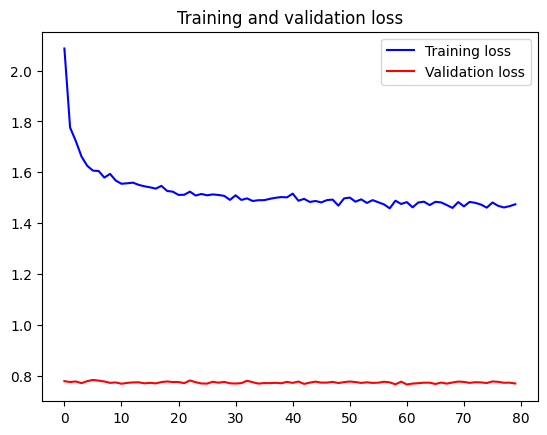

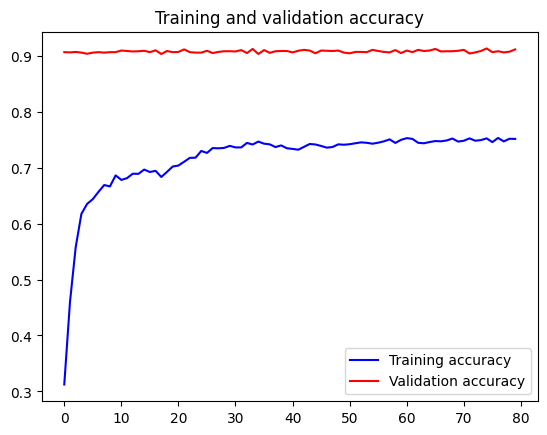

In [35]:
plot_losses(train_loss, test_loss, save_to_file=False)
plot_accuracy(train_acc, test_acc, save_to_file=False)

In [36]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for points, labels in test_dataloader:
        points, labels = points.to(device), labels.to(device)

        outputs = model(points)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())



# In báo cáo
print(classification_report(y_true, y_pred, digits=4))

# Hoặc lưu lại
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')


              precision    recall  f1-score   support

           0     0.9190    0.9904    0.9534      3427
           1     0.8690    0.8343    0.8513       175
           3     0.5306    0.2476    0.3377       105
           4     0.9712    0.9589    0.9650       632
           5     0.0000    0.0000    0.0000        34
           6     0.0000    0.0000    0.0000        57
           7     0.7296    0.7582    0.7436       153
           8     0.7631    0.5292    0.6250       359

    accuracy                         0.9061      4942
   macro avg     0.5978    0.5398    0.5595      4942
weighted avg     0.8816    0.9061    0.8903      4942



/root/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/.venv/lib/python3.10/site-pa

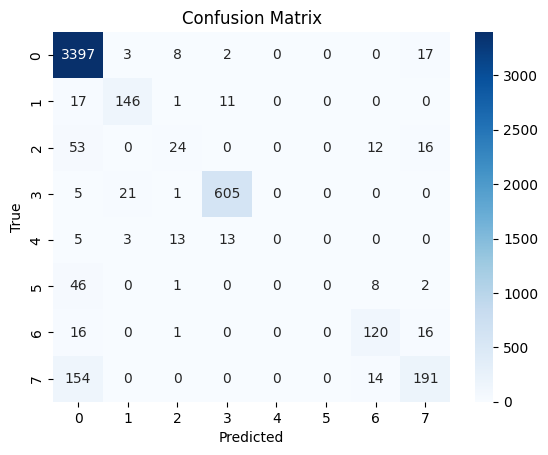

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


<h2> Testing </h2>

In [32]:
# # Ensure model is in evaluation mode
# model.eval()

# # Initialize a list to store predictions
# predictions = []

# with torch.no_grad():
#     for points in test_loader:
#         points = points.to(device)  # Send points to GPU if available
#         outputs = model(points)  # Get predictions
#         _, predicted_classes = torch.max(outputs, 1)  # Predicted class indices
#         predictions.append(predicted_classes.cpu().numpy())  # Store predictions

# # Flatten predictions into a single array
# predictions = np.concatenate(predictions, axis=0)